The link to the dataset is: https://www.kaggle.com/datasets/mdimran6666/heart-disease-nowadays


In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [2]:
# upload data
df = pd.read_csv("balanced_dataset.csv")
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,20.34,0,0,1,0,0,0,0,80,0,0,1,3,7,0,0,0
1,0,24.21,0,0,0,0,0,0,0,77,0,0,0,2,6,0,0,1
2,0,31.64,1,0,0,5,0,1,0,80,0,2,0,2,9,1,0,0
3,0,28.37,1,0,0,0,0,1,1,77,0,2,1,3,8,0,0,0
4,0,28.15,0,0,0,7,0,1,0,80,0,0,0,2,7,0,0,0


In [3]:
# common quick check, do we have missing values, and if so
# in which variables
df.isna().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [4]:
#  Let's compare the variables, can we drop something?

# remember: any variable that doesn't bring anything to the table
# is essentially just noise for the machine learning model
corr_matrix = df.corr()['HeartDisease']
corr_matrix.sort_values(ascending=False)

HeartDisease        1.000000
AgeCategory         0.228244
Stroke              0.153842
Diabetic            0.133383
DiffWalking         0.133204
KidneyDisease       0.108500
Smoking             0.093592
SkinCancer          0.089549
Sex                 0.085658
PhysicalHealth      0.056243
BMI                 0.043703
SleepTime           0.028620
Asthma              0.011460
AlcoholDrinking    -0.033771
Race               -0.045347
PhysicalActivity   -0.053020
MentalHealth       -0.053342
GenHealth          -0.189159
Name: HeartDisease, dtype: float64

In [5]:
 # by inspecting correlation matrix and SelectKBest results
# we decided to drop these variables, since they don't really bring anything into the result
# thus resulting in extra noise in the dataset
removables = ["GenHealth", "MentalHealth", "PhysicalActivity", "Race", "AlcoholDrinking", "Asthma", "SleepTime"]
df = df.drop(removables, axis=1)

In [6]:
# 
df['HeartDisease'] = df['HeartDisease'].replace({0: "No", 1: "Yes"})

In [7]:
df.head()

,HeartDisease,BMI,Smoking,Stroke,PhysicalHealth,DiffWalking,Sex,AgeCategory,Diabetic,KidneyDisease,SkinCancer
0,No,20.34,0,1,0,0,0,80,0,0,0
1,No,24.21,0,0,0,0,0,77,0,0,1
2,No,31.64,1,0,5,1,0,80,2,0,0
3,No,28.37,1,0,0,1,1,77,2,0,0
4,No,28.15,0,0,7,1,0,80,0,0,0


In [8]:
# save the categories into a list
categories = list(np.unique(df['HeartDisease']))
print(categories)

['No', 'Yes']


In [9]:
#  X/y train/test/validation -split

# everything else except the target variable
X = df.drop("HeartDisease", axis=1)

# have only the target variable here (dependent variable)
y_temp = df['HeartDisease']

# since we are doing classification, we have to process our target values with an encoder
# and convert them into a categorical TensorFlow/Keras -format 
le = LabelEncoder()
y_enc = le.fit_transform(y_temp)

# Converting the label into a matrix form
y = tf.keras.utils.to_categorical(y_enc)

In [10]:
y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [11]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on target variable
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

# AgeCategory, Diabetic, Stroke
# have the most impact on the target variable

,Features,Score
6,AgeCategory,59552.11
7,Diabetic,6199.46
2,Stroke,4583.15
4,DiffWalking,3256.44
3,PhysicalHealth,3143.94
8,KidneyDisease,2281.46
9,SkinCancer,1435.77
1,Smoking,1067.90
5,Sex,737.30
0,BMI,335.71


In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [13]:
from tensorflow.keras import layers, models, callbacks
import tensorflow as tf

# Create neural network model
model = tf.keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(l1=0.1)),
        layers.Dense(8, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

# Compile the model
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Define EarlyStopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=5,                # Stop after 5 epochs with no improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

# Train the model with EarlyStopping
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val),  # Use validation data to monitor performance
    epochs=100,                     # Maximum number of epochs
    batch_size=32,                  # Batch size for training
    callbacks=[early_stopping],     # Add the EarlyStopping callback
    verbose=1                       # Show training progress
)


C:\Users\e1003118\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 370 (1.45 KB)

 Trainable params: 350 (1.37 KB)

 Non-trainable params: 20 (80.00 B)

Epoch 1/100
4366/4366 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9222 - loss: 0.8185 - val_accuracy: 0.9244 - val_loss: 0.2483
Epoch 2/100
4366/4366 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9266 - loss: 0.2408 - val_accuracy: 0.9244 - val_loss: 0.2354
Epoch 3/100
4366/4366 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9257 - loss: 0.2361 - val_accuracy: 0.9244 - val_loss: 0.2358
Epoch 4/100
4366/4366 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9260 - loss: 0.2328 - val_accuracy: 0.9244 - val_loss: 0.2320
Epoch 5/100
4366/4366 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9252 - loss: 0.2344 - val_accuracy: 0.9244 - val_loss: 0.2307
Epoch 6/100
4366/4366 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9275 - loss: 0.2277 - val_accuracy: 0.9244 - val_loss: 0.2294
Epoch 7/100
4366/4366 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9262 - loss: 0.2303 - val_accuracy: 0.9244 - val_loss: 0.2310
Epoch 8/100
4366/4366 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9253 - loss: 0

<Axes: >

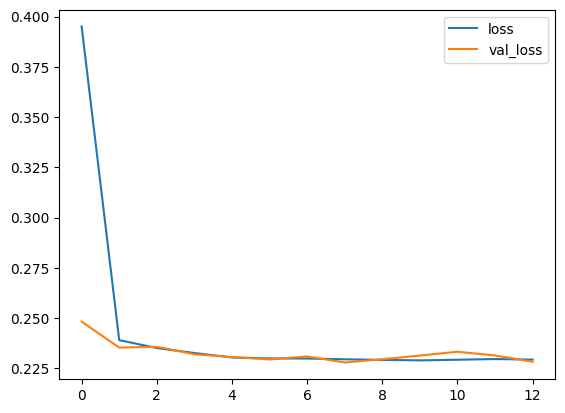

In [ ]:
# first of all,
# only 13 epochs?
# it looks a bit weird
# but let's examine the metrics

loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

# overfitting at epoch 10?
# it looks pretty ok
# but I am still surprised that there are only 13 epochs

<Axes: >

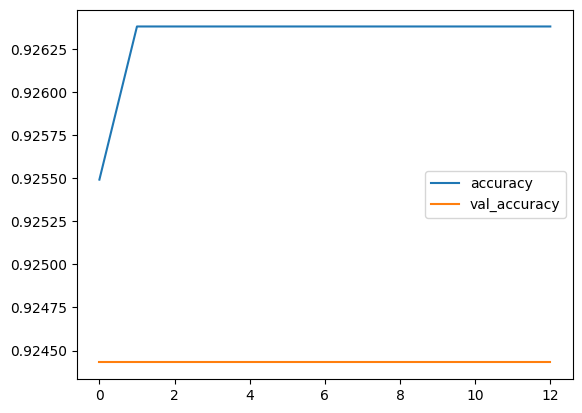

In [ ]:
loss_df[['accuracy', 'val_accuracy']].plot()

# I was not sure that that 12 epochs
# is sufficient but it looks like 
# that it is enough for this model because 
# it did not improve the model further

In [ ]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

# Both training and test are very close, 
# indicating that the model generalizes 
# well to unseen data
# also it states that there is no significant overfitting

Test data evaluation:
[0.2239573448896408, 0.9271731376647949]

Train data evaluation:
[0.22476661205291748, 0.9263787865638733]


In [17]:
 # get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

936/936 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step


<Axes: >

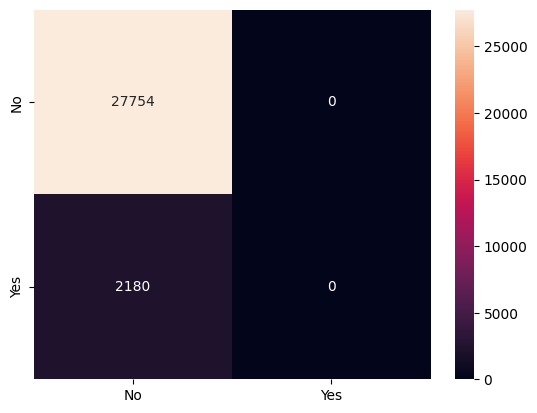

In [ ]:
# confusion matrix
sns.heatmap(confusion_matrix(y_test, test_predictions), xticklabels=categories, yticklabels=categories, annot=True, fmt='g')

# True Negatives (Top-Left)
# False Positives (Top-Right)
# False Negatives (Bottom-Left)
# True Positives (Bottom-Right)

# it looks like for both cases (this and the another neural network
# in this project) the model does not work correctly
# because it predicts always "no"
# and it looks like that it does not matter what input
# you will have, you never get the true positive outcome

In [ ]:
# print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions, target_names=categories))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

# neural network with the earlystop worked a bit better
# than running 400 epochs

# accuracy is 92% which can be interprented as good one
# but knowing that there is a mistake in predictions
# we can skip it

              precision    recall  f1-score   support

          No       0.93      1.00      0.96     27754
         Yes       0.00      0.00      0.00      2180

    accuracy                           0.93     29934
   macro avg       0.46      0.50      0.48     29934
weighted avg       0.86      0.93      0.89     29934


Model overall accuracy: 92.72%


C:\Users\e1003118\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\e1003118\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\e1003118\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classific

In [ ]:
# In multi category classification , AUC values are often interpreted as follows: 
# 0.5-0.6 (failed)
# 0.6-0.7 (worthless)
# 0.7-0.8 (poor)
# 0.8-0.9 (good)
# > 0.9 (excellent)

# get ROC-AUC -score
roc_auc_score(y, model.predict(X), multi_class="ovr")

# also, can skip this good result in the ROC-AUC
# because the model actually does not work

6237/6237 ━━━━━━━━━━━━━━━━━━━━ 5s 861us/step


0.8153520530008904

In [21]:
 df.columns

Index(['HeartDisease', 'BMI', 'Smoking', 'Stroke', 'PhysicalHealth',
       'DiffWalking', 'Sex', 'AgeCategory', 'Diabetic', 'KidneyDisease',
       'SkinCancer'],
      dtype='object')

In [23]:
# let's try with some new imaginary data
# modify this as needed regarding your own dataset
tester_row = {
    'BMI': 20.34, 
    'Smoking': 0, 
    'Stroke': 0,  
    'PhysicalHealth': 4, 
    'DiffWalking': 0, 
    'Sex': 0,
    'AgeCategory': 25,
    'Diabetic': 0, 
    'KidneyDisease': 0,
    'SkinCancer': 0
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])
result = model.predict(tester_row)[0]
result_text = categories[np.argmax(result)]

print(f"Predicted possibility of having a Heart attack: {result_text}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted possibility of having a Heart attack: No
